# CycleGAN

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from PIL import Image
from datetime import datetime
import copy
import os
import random
import time
from tqdm import tqdm

## Generator

<img src="images/generator.png" width=900>

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(channels),
        )
    
    def forward(self, x):
        return self.net(x) + x

ResidualBlock(10)(torch.randn(8, 10, 16, 16)).shape

torch.Size([8, 10, 16, 16])

In [4]:
class DownLayer(nn.Module):
    def __init__(self, in_channels, out_channels, use_instance_norm=True, kernel_size=3, activation='relu'):
        super().__init__()

        assert activation in ['relu', 'leaky_relu']
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1, stride=2, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels) if use_instance_norm else nn.Identity(),
            nn.ReLU() if activation == 'relu' else nn.LeakyReLU(negative_slope=0.2)
        )
    
    def forward(self, x):
        return self.net(x)

DownLayer(10, 20)(torch.randn(8, 10, 16, 16)).shape

torch.Size([8, 20, 8, 8])

In [5]:
class UpLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, padding=1, stride=2, output_padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.net(x)

UpLayer(20, 10)(torch.randn(8, 20, 8, 8)).shape

torch.Size([8, 10, 16, 16])

In [6]:
class Generator(nn.Module):
    def __init__(self, img_channels=3, start_hidden_channels=64, num_res_blocks=8):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(img_channels, start_hidden_channels, kernel_size=7, padding=3, padding_mode='reflect'),
            DownLayer(start_hidden_channels, start_hidden_channels*2),
            DownLayer(start_hidden_channels*2, start_hidden_channels*4),
            *[ResidualBlock(start_hidden_channels*4) for _ in range(num_res_blocks)],
            UpLayer(start_hidden_channels*4, start_hidden_channels*2),
            UpLayer(start_hidden_channels*2, start_hidden_channels),
            nn.Conv2d(start_hidden_channels, img_channels, kernel_size=7, padding=3, padding_mode='reflect'),
            # nn.Tanh()
        )
    
    def forward(self, x):
        return self.net(x)

Generator()(torch.randn(8, 3, 64, 64)).shape

torch.Size([8, 3, 64, 64])

## PatchGAN Discriminator

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_channels=3, hidden_dim=64):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(input_channels, hidden_dim, kernel_size=7, padding=3, padding_mode='reflect'),
            DownLayer(hidden_dim, hidden_dim*2, use_instance_norm=False, kernel_size=4, activation='leaky_relu'),
            DownLayer(hidden_dim*2, hidden_dim*4, kernel_size=4, activation='leaky_relu'),
            DownLayer(hidden_dim*4, hidden_dim*8, kernel_size=4, activation='leaky_relu'),
            nn.Conv2d(hidden_dim*8, 1, kernel_size=1)
        )
    
    def forward(self, x):
        return self.net(x)


Discriminator()(torch.randn(4, 3, 64, 64)).shape

torch.Size([4, 1, 8, 8])

## CycleGAN Loss

In [7]:
class CyclaGANLoss:
    def __init__(self, lambda_identity=0.1, lambda_cycle=10):
        self.adv_criterion = nn.MSELoss()
        self.reconstruction_criterion = nn.L1Loss() 

        self.lambda_identity=0.1
        self.lambda_cycle=10

    def disc_loss(self, real, fake, disc):
        real_preds = disc(real)
        fake_preds = disc(fake)

        loss = (self.adv_criterion(fake_preds, torch.zeros_like(fake_preds)) + self.adv_criterion(real_preds, torch.ones_like(real_preds))) / 2

        return loss
    
    def generators_loss(self, gen_AB, gen_BA, disc_A, disc_B, real_A, real_B):
        adv_loss_AB, fake_B = self._gen_adversarial_loss(gen_AB, real_A, disc_B)
        adv_loss_BA, fake_A = self._gen_adversarial_loss(gen_BA, real_B, disc_A)
        adv_loss = adv_loss_AB + adv_loss_BA

        identity_loss = self._identity_loss(real_B, gen_AB)
        identity_loss += self._identity_loss(real_A, gen_BA)

        cycle_loss = self._cycle_consistency_loss(real_A, fake_B, gen_BA)
        cycle_loss += self._cycle_consistency_loss(real_B, fake_A, gen_AB)

        loss = adv_loss + self.lambda_identity * identity_loss + self.lambda_cycle * cycle_loss

        return loss

    def _gen_adversarial_loss(self, gen_AB, real_A, disc_B):
        fake_B = gen_AB(real_A)
        preds = disc_B(fake_B)
        loss = self.adv_criterion(preds, torch.ones_like(preds))
        
        return loss, fake_B

    def _identity_loss(self, real_B, gen_AB):
        return self.reconstruction_criterion(gen_AB(real_B), real_B)

    def _cycle_consistency_loss(self, real_A, fake_B, gen_BA):
        return self.reconstruction_criterion(gen_BA(fake_B), real_A)

## Training

In [8]:
class CustomRandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p
    
    def __call__(self, x):
        if random.random() < self.p:
            x[:, :, :x.shape[2]//2] = transforms.functional.hflip(x[:, :, :x.shape[2]//2])
            x[:, :, x.shape[2]//2:] = transforms.functional.hflip(x[:, :, x.shape[2]//2:])
        
        return x


transform = transforms.Compose([
    transforms.Resize((64, ), transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    CustomRandomHorizontalFlip(),
])
img_folder_dataset = torchvision.datasets.ImageFolder(root='../../data/edges2shoes/', transform=transform)

In [9]:
class Edge2ShoesDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder_dataset: torchvision.datasets.ImageFolder, transform=None):
        self.img_folder_dataset = image_folder_dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.img_folder_dataset)
    
    def __getitem__(self, idx):
        edges, shoes = torch.chunk(self.img_folder_dataset[idx][0], 2, dim=2)
        if self.transform is not None:
            edges, shoes = self.transform(edges), self.transform(shoes)
        
        return edges, shoes
    
dataset = Edge2ShoesDataset(img_folder_dataset)

In [10]:
def generate_images_and_save(gen_AB: Generator, gen_BA: Generator, data: list, epoch: int, path: str, device):
    
    os.makedirs(path, exist_ok=True)

    with torch.no_grad():
        real_A = torch.stack([d[0] for d in data])
        real_B = torch.stack([d[1] for d in data])

        fake_B = gen_AB(real_A.to(device)).detach().cpu().clip(0, 1)
        fake_A = gen_BA(real_B.to(device)).detach().cpu().clip(0, 1)

        _, C, H, W = real_A.shape
        imgs = torch.cat([real_A.unsqueeze(1), fake_A.unsqueeze(1), fake_B.unsqueeze(1), real_B.unsqueeze(1)], dim=1).view(-1, C, H, W)
        imgs = torchvision.utils.make_grid(imgs, nrow=4)
        imgs = transforms.Resize(1500)(imgs).permute(1, 2, 0).numpy()
    
    filename = f"Epoch {epoch}.png"
    
    plt.imsave(os.path.join(path, filename), imgs)

In [11]:
def save_models_and_state(
    gen_AB: Generator,
    gen_BA: Generator,
    disc_A: Discriminator,
    disc_B: Discriminator,
    opt_gen: torch.optim.Adam,
    opt_disc_A: torch.optim.Adam,
    opt_disc_B: torch.optim.Adam,
    state: dict,
    path: str
):
    os.makedirs(path, exist_ok=True)
    
    torch.save(gen_AB.state_dict(), os.path.join(path, 'gen_AB.pth'))
    torch.save(gen_BA.state_dict(), os.path.join(path, 'gen_BA.pth'))
    torch.save(disc_A.state_dict(), os.path.join(path, 'disc_A.pth'))
    torch.save(disc_B.state_dict(), os.path.join(path, 'disc_B.pth'))
    torch.save(opt_gen.state_dict(), os.path.join(path, 'opt_gen.pth'))
    torch.save(opt_disc_A.state_dict(), os.path.join(path, 'opt_disc_A.pth'))
    torch.save(opt_disc_B.state_dict(), os.path.join(path, 'opt_disc_B.pth'))
    torch.save(state, os.path.join(path, 'state.pth'))

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [13]:
BATCH_SIZE = 64
EPOCHS=50
device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

cuda


In [14]:
gen_AB = Generator().to(device)
gen_BA = Generator().to(device)
disc_A = Discriminator().to(device)
disc_B = Discriminator().to(device)

gen_opt = torch.optim.Adam(list(gen_AB.parameters()) + list(gen_BA.parameters()), lr=0.0002, betas=(0.5, 0.999))
disc_A_opt = torch.optim.Adam(disc_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_B_opt = torch.optim.Adam(disc_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

gen_AB = gen_AB.apply(weights_init)
gen_BA = gen_BA.apply(weights_init)
disc_A = disc_A.apply(weights_init)
disc_B = disc_B.apply(weights_init)

cycle_gan_loss = CyclaGANLoss()


dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [19]:
from_checkpoint = True

if from_checkpoint:
    state_root = 'results/'

    gen_AB.load_state_dict(torch.load(os.path.join(state_root, 'gen_AB.pth')))
    gen_BA.load_state_dict(torch.load(os.path.join(state_root, 'gen_BA.pth')))
    disc_A.load_state_dict(torch.load(os.path.join(state_root, 'disc_A.pth')))
    disc_B.load_state_dict(torch.load(os.path.join(state_root, 'disc_B.pth')))
    gen_opt.load_state_dict(torch.load(os.path.join(state_root, 'opt_gen.pth')))
    disc_A_opt.load_state_dict(torch.load(os.path.join(state_root, 'opt_disc_A.pth')))
    disc_B_opt.load_state_dict(torch.load(os.path.join(state_root, 'opt_disc_B.pth')))

    state = torch.load(os.path.join(state_root, 'state.pth'))
else:
    state = {}

state

{'epoch': 46}

In [88]:
eval_data = [dataset[i] for i in range(12)]

for epoch in range(EPOCHS):
    epoch_start_time = time.time()

    for edges, shoes in dataloader:
        real_A, real_B = edges.to(device), shoes.to(device)
        
        #----- Updating the Discriminator A -----#
        with torch.no_grad():
            fake_A = gen_BA(real_B)
        loss = cycle_gan_loss.disc_loss(real_A, fake_A, disc_A)
        disc_A_opt.zero_grad()
        loss.backward(retain_graph=True)
        disc_A_opt.step()
        
        #----- Updating the Discriminator B -----#
        with torch.no_grad():
            fake_B = gen_AB(real_A)
        loss = cycle_gan_loss.disc_loss(real_B, fake_B, disc_B)
        disc_B_opt.zero_grad()
        loss.backward(retain_graph=True)
        disc_B_opt.step()

        #----- Updating the Generators -----#
        loss = cycle_gan_loss.generators_loss(gen_AB, gen_BA, disc_A, disc_B, real_A, real_B)
        gen_opt.zero_grad()
        loss.backward()
        gen_opt.step()
    
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Epoch {epoch} [Epoch time: {time.time() - epoch_start_time}]")
    generate_images_and_save(gen_AB, gen_BA, data=eval_data, epoch=epoch, path='results', device=device)
    save_models_and_state(gen_AB, gen_BA, disc_A, disc_B, gen_opt, disc_A_opt, disc_B_opt, {"epoch": epoch}, 'results/')

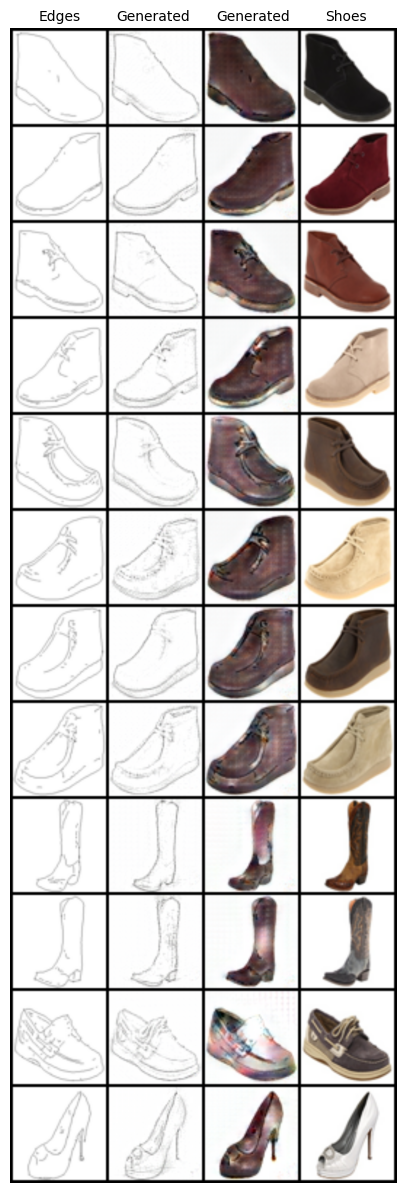

In [49]:
data = [dataset[i] for i in range(12)]

real_A = torch.stack([d[0] for d in data])
real_B = torch.stack([d[1] for d in data])

fake_B = gen_AB(real_A.to(device)).detach().cpu().clip(0, 1)
fake_A = gen_BA(real_B.to(device)).detach().cpu().clip(0, 1)

_, C, H, W = real_A.shape
imgs = torch.cat([real_A.unsqueeze(1), fake_A.unsqueeze(1), fake_B.unsqueeze(1), real_B.unsqueeze(1)], dim=1).view(-1, C, H, W)
imgs = torchvision.utils.make_grid(imgs, nrow=4)
imgs = transforms.Resize(1500)(imgs).permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 15))
plt.axis("off")
plt.text(110, -30, "Edges")
plt.text(410, -30, "Generated")
plt.text(800, -30, "Generated")
plt.text(1220, -30, "Shoes")
plt.imshow(imgs);

## Further improvements (not in the original paper and implementation)

As evident from the visual examples above, the generator consistently applies a similar color palette, leaning towards shades of brown. To address this concern, an effective strategy could involve the incorporation of the *Mini-Batch Standard Deviation* module (as introduced in StyleGAN) within the discriminators. The ensuing outcomes of this approach are showcased below

<img src="images/minibatchstd.png" width=350>